In [168]:
# TV Shows Analysis

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from itertools import combinations
from collections import Counter

In [170]:
df = pd.read_csv("dataset.csv")

In [171]:
# Check if we can abandon "unreliable" ratings by little amount of votes
df["vote_count"].quantile([0.25, 0.50, 0.75])

0.25      4.0
0.50     23.0
0.75    128.0
Name: vote_count, dtype: float64

In [172]:

C = df["vote_average"].mean()
m = df["vote_count"].quantile(0.60)

df["weighted_rating"] = (
    (df["vote_count"] / (df["vote_count"] + m)) * df["vote_average"] +
    (m / (df["vote_count"] + m)) * C
)
df["weighted_rating"].describe()

count    10000.000000
mean         6.905148
std          0.548223
min          3.797105
25%          6.550364
50%          6.704843
75%          7.195337
max          8.913394
Name: weighted_rating, dtype: float64

In [173]:
# Convert genre strings 
df["genre_ids"] = df["genre_ids"].apply(ast.literal_eval) 
df = df.explode("genre_ids").reset_index(drop=True) 
df = df.rename(columns={"genre_ids": "genre_id"}) 

In [174]:
genres = pd.read_csv("genres.csv") 
df = df.merge(genres, left_on="genre_id", right_on="id_genre", how="left" ) 

In [175]:
df = df.drop(columns=["id_genre"])

In [177]:
df_genre = df.dropna(subset=["genre_id"])

# Genres in production to popularity of genres in past 2 years
Examining what genres were most produced in recent 2 years and what genres were highest by popularity for the same period.

Using Bayesian for 'popularity'

In [178]:
df["first_air_date"] = pd.to_datetime(df["first_air_date"], errors="coerce")
two_years_ago = pd.Timestamp.now() - pd.DateOffset(years=2)

df_recent = df[df["first_air_date"] >= two_years_ago]
df_genre_recent = df_recent.dropna(subset=["genre_id", "genre_name"])

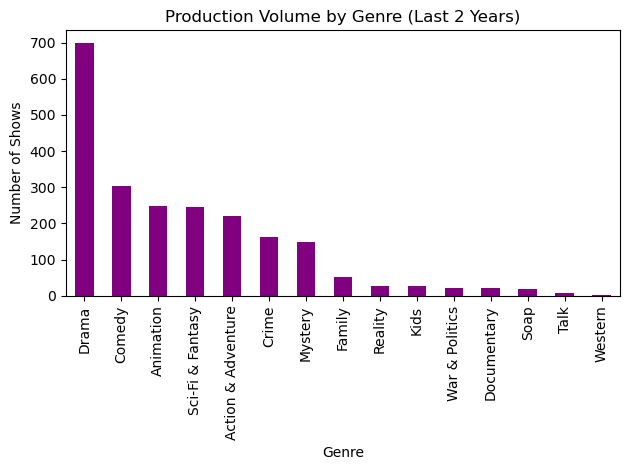

In [179]:
production_recent = (
    df_genre_recent
    .groupby("genre_name")
    .size()
    .sort_values(ascending=False)
)

plt.figure()
production_recent.plot(kind="bar", color = "purple")
plt.title("Production Volume by Genre (Last 2 Years)")
plt.xlabel("Genre")
plt.ylabel("Number of Shows")
plt.tight_layout()
plt.savefig("production.png", dpi=300, bbox_inches="tight")
plt.show()


In [180]:
genre_stats = df_genre_recent.groupby("genre_name")["popularity"].agg(["count", "mean"])
global_mean = df_genre_recent["popularity"].mean()
m = genre_stats["count"].quantile(0.25)
genre_stats["popularity_shrunk"] = (
    (genre_stats["count"] / (genre_stats["count"] + m)) * genre_stats["mean"]
    + (m / (genre_stats["count"] + m)) * global_mean
)

genre_stats = genre_stats.sort_values("popularity_shrunk", ascending=False)


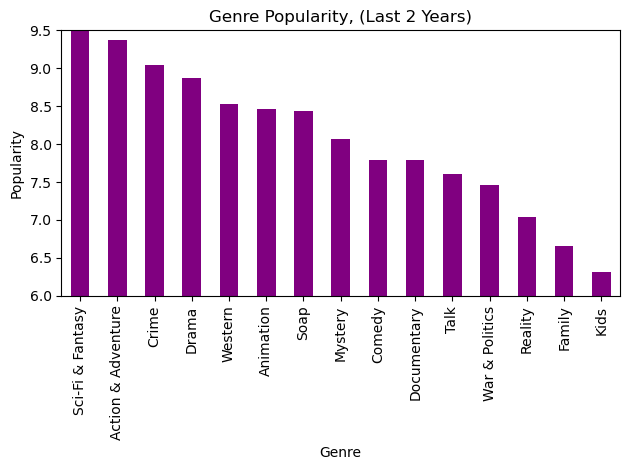

In [181]:
plt.figure()
genre_stats["popularity_shrunk"].plot(kind="bar", color = "purple")
plt.title("Genre Popularity, (Last 2 Years)")
plt.xlabel("Genre")
plt.ylabel("Popularity")
plt.ylim(6, 9.5) 
plt.tight_layout()
plt.savefig("popularity.png", dpi=300, bbox_inches="tight")
plt.show()


# Each genre Golden Age
Based on popularity and volume of production

In [182]:
PRODUCTION = 0.6 # how much producers consider genre to be if importance
QUALITY = 0.4 # how well the show turned out to be 
MIN_LEN = 3 # min length of golden age to prevent from single year spikes

df_genre = df.dropna(subset=["genre_id", "genre_name"]).copy()

#
df_genre["first_air_date"] = pd.to_datetime(
    df_genre["first_air_date"],
    errors="coerce"
)

df_genre["year"] = df_genre["first_air_date"].dt.year

df_genre_time = df_genre.dropna(subset=["year", "weighted_rating"]).copy()
df_genre_time["year"] = df_genre_time["year"].astype(int)


In [183]:
MIN_GENRE_SIZE = 20

genre_counts = (
    df_genre_time
    .groupby("genre_name")
    .size()
)

valid_genres = genre_counts[genre_counts >= MIN_GENRE_SIZE].index

df_genre_time = df_genre_time[
    df_genre_time["genre_name"].isin(valid_genres)
].copy()


In [184]:
"""
yearly_production = (
    df_genre_time
    .groupby(["genre_name", "year"])
    .size()
    .rename("production")
    .reset_index()
)
"""

yearly_quality = (
    df_genre_time
    .groupby(["genre_name", "year"])["weighted_rating"]
    .mean()
    .rename("quality")
    .reset_index()
)


# Total number of shows released each year by genre
yearly_genre_counts = (
    df_genre_time
    .groupby(["year", "genre_name"])
    .size()
    .rename("genre_count")
    .reset_index()
)

# Total number of shows released by year
yearly_total_counts = (
    df_genre_time
    .groupby("year")
    .size()
    .rename("total_count")
    .reset_index()
)

# join so each genre knows total number of shows during its year
yearly_production = pd.merge(
    yearly_genre_counts,
    yearly_total_counts,
    on="year",
    how="left"
)

# Share of each genre from all shows
yearly_production["shareFromTotal"] = (
    yearly_production["genre_count"] /
    yearly_production["total_count"]
)

yearly_production = yearly_production[["genre_name", "year", "shareFromTotal"]]



In [185]:
yearly = pd.merge(
    yearly_production,
    yearly_quality,
    on=["genre_name", "year"],
    how="inner"
)

yearly = yearly.dropna(subset=["year", "quality"]).copy()
yearly_norm = yearly.copy()


In [186]:
yearly_norm["prod_norm"] = (
    yearly_norm
    .groupby("genre_name")["shareFromTotal"]
    .transform(lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0)
)

yearly_norm["quality_norm"] = (
    yearly_norm
    .groupby("genre_name")["quality"]
    .transform(lambda x: (x - x.mean()) / x.std() if x.std() != 0 else 0)
)


In [187]:
w_prod = PRODUCTION
w_qual = QUALITY

yearly_norm["golden_score"] = (
    w_prod * yearly_norm["prod_norm"] +
    w_qual * yearly_norm["quality_norm"]
)

In [188]:
golden_joint = []

for genre, gdf in yearly_norm.groupby("genre_name"):
    
    ts = gdf.set_index("year")["golden_score"].sort_index()
    
    threshold = ts.quantile(0.75)   # top 25% of combined strength
    mask = ts >= threshold
    
    groups = (mask != mask.shift()).cumsum()
    blocks = ts[mask].groupby(groups)
    
    for _, block in blocks:
        golden_joint.append({
            "genre": genre,
            "start": int(block.index.min()),
            "end": int(block.index.max()),
            "years_long": int(block.index.max() - block.index.min() + 1),
            "avg_golden_score": block.mean()
        })

golden_joint_df = pd.DataFrame(golden_joint)


In [189]:
best_blocks = []

for genre, gdf in golden_joint_df.groupby("genre"):
    
    gdf_sorted = gdf.sort_values("avg_golden_score", ascending=False)
    
    valid = gdf_sorted[gdf_sorted["years_long"] >= MIN_LEN]
    
    if not valid.empty:
        best_blocks.append(valid.iloc[0])
    else:
        fallback = (
            gdf_sorted
            .sort_values(["years_long", "avg_golden_score"], ascending=[False, False])
            .iloc[0]
        )
        best_blocks.append(fallback)

golden_joint_best = pd.DataFrame(best_blocks)


In [190]:
golden_joint_best

,genre,start,end,years_long,avg_golden_score
1,Action & Adventure,1966,1968,3,1.182742
14,Animation,1999,2002,4,0.820896
24,Comedy,1989,1991,3,0.626352
32,Crime,1949,1951,3,1.161816
49,Documentary,1962,1964,3,0.296671
65,Drama,2017,2025,9,1.021523
66,Family,1950,1954,5,1.143192
80,Kids,1983,1985,3,0.983135
99,Mystery,2018,2024,7,0.715781
100,News,1947,1961,15,1.232486


## Ploting

In [191]:
streaming = pd.read_csv("services.csv")
streaming["launch_year"] = streaming["launch_year"].astype(int)

In [192]:
service_colors = {
    "Amazon Prime": "orange",
    "Netflix": "red",
    "Hulu": "green",
    "Apple TV+": "pink",  
    "Disney+": "blue",
    "iQIYI": "purple",
    "Tencent Video": "black"
}

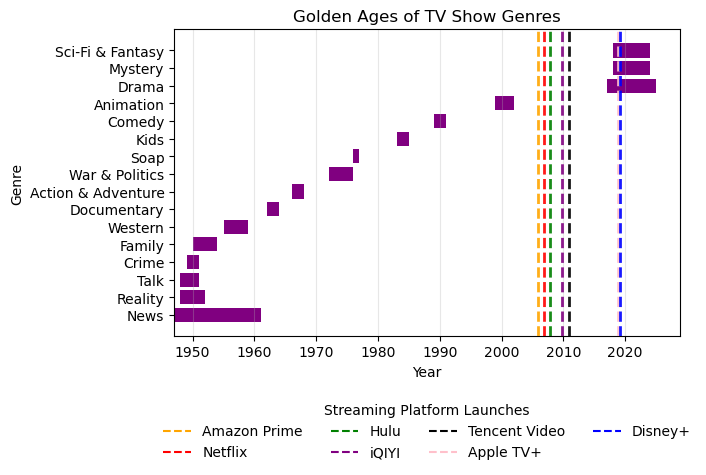

In [193]:
golden_plot = golden_joint_best.sort_values("start")

plt.figure(figsize=(7, 5))

plt.barh(
    golden_plot["genre"],
    golden_plot["end"] - golden_plot["start"],
    left=golden_plot["start"],
    color = "purple"
)

year_groups = streaming.groupby("launch_year")

for year, group in year_groups:
    offsets = np.linspace(-0.15, 0.15, len(group))  # visual separation

    for offset, (_, row) in zip(offsets, group.iterrows()):
        plt.axvline(
            x=year + offset,  
            linestyle="--",
            linewidth=2,
            alpha=0.9,
            color=service_colors.get(row["service"], "gray"),
            zorder=5
        )

handles = [
    plt.Line2D(
        [0], [0],
        linestyle="--",
        linewidth=1.5,
        color=service_colors[s],
        label=s
    )
    for s in streaming["service"].unique()
]

plt.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    ncol=4,
    frameon=False,
    title="Streaming Platform Launches"
)

plt.xlabel("Year")
plt.ylabel("Genre")
plt.title("Golden Ages of TV Show Genres")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig("goldenages.png", dpi=300, bbox_inches="tight")
plt.show()

# Genres combinations

In [194]:
df_clean = df.dropna(subset=["genre_name", "id"]).copy()

df_combo = (
    df_clean
    .groupby("id")["genre_name"]
    .apply(lambda x: tuple(sorted(set(x))))   # remove duplicates + normalize order
    .reset_index(name="combo_key")
)

df_combo["combo_size"] = df_combo["combo_key"].apply(len)


In [195]:
df_combo["combo_size"] = df_combo["combo_key"].apply(len)

In [196]:
combo_frequency_table = (
    df_combo
    .groupby("combo_key")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

combo_frequency_table.head(20)

,combo_key,count
357,"(Drama,)",1184
220,"(Comedy,)",640
246,"(Comedy, Drama)",487
419,"(Reality,)",404
307,"(Crime, Drama)",362
154,"(Animation, Comedy)",254
63,"(Action & Adventure, Animation, Sci-Fi & Fantasy)",246
387,"(Drama, Soap)",230
311,"(Crime, Drama, Mystery)",222
428,"(Talk,)",203


In [197]:
max_size = df_combo["combo_size"].max()

max_size_combos = (
    df_combo[df_combo["combo_size"] == max_size]
    [["combo_key"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

max_size, max_size_combos


(7,
                                            combo_key
 0  (Action & Adventure, Animation, Comedy, Drama,...
 1  (Action & Adventure, Animation, Comedy, Family...
 2  (Action & Adventure, Animation, Comedy, Crime,...)

In [198]:
genre_count_distribution = (
    df_combo
    .groupby("combo_size")
    .size()
    .reset_index(name="num_shows")
    .sort_values("combo_size")
)

genre_count_distribution


,combo_size,num_shows
0,1,3008
1,2,3191
2,3,2193
3,4,834
4,5,172
5,6,57
6,7,7


In [199]:
max_genres = df_combo["combo_size"].max()
max_genres


7

In [200]:
# Find the maximum number of genres in any combo
max_size = df_combo["combo_size"].max()

# Filter only those max-size combos
max_size_df = df_combo[df_combo["combo_size"] == max_size].copy()

# Count how often each max combo appears
max_combo_counts = (
    max_size_df
    .groupby("combo_key")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)


In [201]:
max_genre_shows = df_combo[df_combo["combo_size"] == max_genres]


In [202]:
max_genre_shows_named = max_genre_shows.merge(
    df[["id", "name", "original_name"]],
    on="id",
    how="left"
)

max_genre_shows_named["show_name"] = (
    max_genre_shows_named["name"]
    .fillna(max_genre_shows_named["original_name"])
)

In [203]:
clean_max_genre_shows_named = (
    max_genre_shows_named
    .groupby(["id", "show_name"], as_index=False)
    .agg({
        "combo_key": "first",
        "combo_size": "first"
    })
)


In [204]:
for row in clean_max_genre_shows_named.itertuples(index=False):
    print(f"Name: {row.show_name}")
    print("Genres:", ", ".join(row.combo_key))
    print("-" * 90)

Name: Battle B-Daman
Genres: Action & Adventure, Animation, Comedy, Drama, Family, Kids, Sci-Fi & Fantasy
------------------------------------------------------------------------------------------
Name: Gravity Falls
Genres: Action & Adventure, Animation, Comedy, Family, Kids, Mystery, Sci-Fi & Fantasy
------------------------------------------------------------------------------------------
Name: Crush Gear Turbo
Genres: Action & Adventure, Animation, Comedy, Drama, Family, Kids, Sci-Fi & Fantasy
------------------------------------------------------------------------------------------
Name: Wedding Peach
Genres: Action & Adventure, Animation, Comedy, Drama, Family, Kids, Sci-Fi & Fantasy
------------------------------------------------------------------------------------------
Name: Go! Princess PreCure
Genres: Action & Adventure, Animation, Comedy, Drama, Family, Kids, Sci-Fi & Fantasy
------------------------------------------------------------------------------------------
Name: B